In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
race_df = pd.read_parquet('./data/race_test_prepared.parquet')
race_df = race_df[race_df['fk_score'] <= 15]
race_df

,example_id,article,answer,question,options,difficulty,text,embeddings_mini_lm,embeddings_bge_large,fk_score,fk_score_categ
0,middle6673.txt,Mother loves her son. But he is a bad boy. He ...,2,What does the boy do every day?,['He goes to school.' 'He cooks every day.'\n ...,M,### CONTEXT ###\nMother loves her son. But he ...,"[-0.08285892754793167, 0.08668268471956253, 0....","[0.7998983263969421, -0.16793034970760345, 0.2...",1.428839,easy
1,middle5072.txt,Do you help with chores at home? These are wha...,1,What can we learn from the passage?,['Manuel is good at cooking.' 'Maybe Arthur ha...,M,### CONTEXT ###\nDo you help with chores at ho...,"[-0.09754877537488937, 0.041119806468486786, 0...","[-0.12698052823543549, 0.05871523171663284, -0...",4.094385,easy
2,middle6965.txt,"As kids, we learn how to write, maybe play a m...",1,"In the writer's first coding class, she _ .",['made apps and games' 'created a web page' 'w...,M,"### CONTEXT ###\nAs kids, we learn how to writ...","[-0.02396281808614731, 0.041761502623558044, 0...","[0.6323241591453552, -0.1685527265071869, -0.2...",7.015463,medium
3,middle7159.txt,If you could see a movie of your life before y...,2,What troubles Allison after graduation?,"[""She couldn't find a well-paid job.""\n 'She h...",M,### CONTEXT ###\nIf you could see a movie of y...,"[-0.0020361344795674086, 0.042117245495319366,...","[0.44568178057670593, 0.2012404501438141, 0.11...",5.936928,easy
4,middle432.txt,Did you notice the number on the book in a lib...,1,"According to the reading, which sentence is TRUE?","[""The number on a book can't be bigger than 90...",M,### CONTEXT ###\nDid you notice the number on ...,"[-0.0014026855351403356, 0.028585389256477356,...","[1.5601633787155151, 0.3308599591255188, 0.183...",5.239505,easy
...,...,...,...,...,...,...,...,...,...,...,...
2086,2664.txt,Not everyone in the world requires the same am...,1,Which of the following is TRUE according to th...,['Americans are trained to live in large rooms...,C,### CONTEXT ###\nNot everyone in the world req...,"[0.053262945264577866, -0.10596633702516556, 0...","[1.0040448904037476, -0.6670923233032227, 0.01...",8.981492,medium
2087,3785.txt,In 1977 ecologists Stephen Hubbell and Leslie ...,0,"According to paragraph 4, why did Hubbell and ...",['To determine whether the availability of pot...,C,### CONTEXT ###\nIn 1977 ecologists Stephen Hu...,"[-0.017380768433213234, 0.048852842301130295, ...","[0.6190937757492065, -0.255521297454834, 0.336...",12.504105,hard
2088,2012.txt,The spectacular aurora light displays that app...,0,Which of the following terms is defined in the...,"['""magnetosphere"" (line 6)' '""electrons"" (line...",C,### CONTEXT ###\nThe spectacular aurora light ...,"[-0.054313406348228455, 0.03299275040626526, 0...","[0.5124013423919678, -0.7839702367782593, 0.02...",11.571709,hard
2089,1641.txt,"Flying over a desert area in an airplane, two ...",2,"The study of trees,branches and roots indicate...",['there were larger amounts of gold in the bra...,C,### CONTEXT ###\nFlying over a desert area in ...,"[0.09339334070682526, 0.03183355554938316, 0.0...","[0.3303855061531067, 0.4875277578830719, 0.108...",7.440244,medium


In [3]:
def train_linear_regression_with_cv(df, embeddings_col, y_col):
    X = np.array(df[embeddings_col].tolist())
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    
    y = df[y_col].values
    
    kf = KFold(n_splits=7, shuffle=True, random_state=369)
    
    best_model = None
    best_error = float('inf')
    
    for train_index, val_index in kf.split(df):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        predictions = model.predict(X_val)
        error = mean_squared_error(y_val, predictions)
        
        if error < best_error:
            best_error = error
            best_model = model
    
    return best_model

In [4]:
clf = train_linear_regression_with_cv(df=race_df, embeddings_col='embeddings_mini_lm', y_col='fk_score')

In [5]:
def get_predictions(df, clf, embeddings_col, y_col):
    X = np.array(df[embeddings_col].tolist())
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    
    y = df[y_col].values

    y_pred = clf.predict(X)

    print('MSE:', mean_squared_error(y, y_pred))
    print('MAE:', mean_absolute_error(y, y_pred))
    print('R2:', r2_score(y, y_pred))

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y, y=y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

MSE: 6.783675925731749
MAE: 2.0632689062318783
R2: 0.4143492697217608


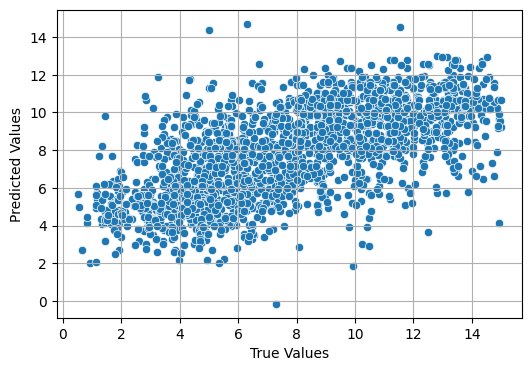

In [6]:
get_predictions(df=race_df, clf=clf, embeddings_col='embeddings_mini_lm', y_col='fk_score')

In [7]:
# race_df['score_easy'] = clf.predict_proba(X=np.array(race_df['embeddings_mini_lm'].tolist()))[:,0]
# race_df['score_hard'] = clf.predict_proba(X=np.array(race_df['embeddings_mini_lm'].tolist()))[:,1]
# race_df['score_medium'] = clf.predict_proba(X=np.array(race_df['embeddings_mini_lm'].tolist()))[:,2]

# race_df['w_easy_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x * clf.coef_[0])
# race_df['w_hard_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x * clf.coef_[1])
# race_df['w_medium_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x * clf.coef_[2])
# race_df['iw_easy_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x / clf.coef_[0])
# race_df['iw_hard_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x / clf.coef_[1])
# race_df['iw_medium_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x / clf.coef_[2])

race_df['score'] = clf.predict(X=np.array(race_df['embeddings_mini_lm'].tolist()))
race_df['absolute_error'] = np.abs(np.array(race_df['fk_score']) - clf.predict(X=np.array(race_df['embeddings_mini_lm'].tolist())))
race_df['w_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x * clf.coef_)
race_df['iw_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x / clf.coef_)

In [8]:
def get_cluster_stats(df, cluster_col, score_col):
    return df.groupby(cluster_col).agg(
        score_mean=pd.NamedAgg(column=score_col, aggfunc='mean'), 
        score_std =pd.NamedAgg(column=score_col, aggfunc='std')
    ).reset_index(drop=False).rename(columns={cluster_col: 'cluster_id'})

n_clusters = 20
seed=0
uw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in race_df['embeddings_mini_lm']])
w_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in race_df['w_embeddings']])
iw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in race_df['iw_embeddings']])

race_df['uw_kmeans'] = uw_kmeans.labels_
race_df['w_kmeans'] = w_kmeans.labels_
race_df['iw_kmeans'] = iw_kmeans.labels_

# cs_unweighted = get_cluster_stats(dd2, 'unweighted_kmeans', 'score')
# cs_weighted = get_cluster_stats(dd2, 'weighted_kmeans', 'score')
# cs_inverse_weighted = get_cluster_stats(dd2, 'inverse_weighted_kmeans', 'score')

In [9]:
cluster_df = race_df[['uw_kmeans', 'w_kmeans', 'iw_kmeans', 'score', 'absolute_error']]
cluster_df = pd.melt(cluster_df, id_vars=['score', 'absolute_error'], var_name='weighting', value_name='cluster_id')
cluster_df = cluster_df.groupby(['weighting', 'cluster_id']).agg({'score': ['mean', 'var'], 'absolute_error': ['mean', 'var']}).reset_index()
cluster_df.columns = ['weighting', 'cluster_id', 'mean_score', 'var_score', 'mean_absolute_error', 'var_absolute_error']

In [10]:
cluster_df

,weighting,cluster_id,mean_score,var_score,mean_absolute_error,var_absolute_error
0,iw_kmeans,0,7.482467,5.645377,2.100618,2.834302
1,iw_kmeans,1,8.407074,4.488924,2.218179,2.578163
2,iw_kmeans,2,7.106644,4.456006,2.223249,2.612350
3,iw_kmeans,3,8.171707,5.995782,2.036957,2.321053
4,iw_kmeans,4,6.631223,4.185606,1.933191,2.505134
5,iw_kmeans,5,8.306440,7.841751,1.881843,2.370365
6,iw_kmeans,6,7.035086,3.959500,2.350580,3.004876
7,iw_kmeans,7,9.959799,1.272920,1.716260,1.269454
8,iw_kmeans,8,6.919270,4.487887,2.122772,2.702171
9,iw_kmeans,9,8.225344,4.929775,2.256129,2.986420


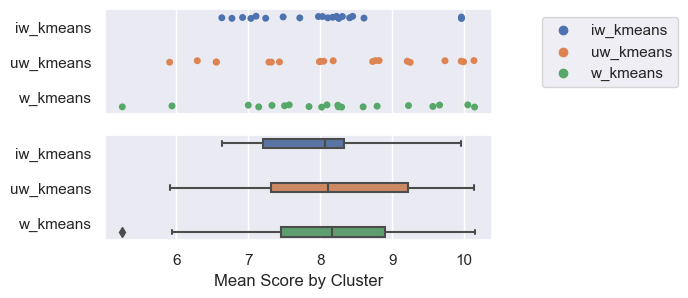

In [11]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='mean_score', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='mean_score', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Mean Score by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()

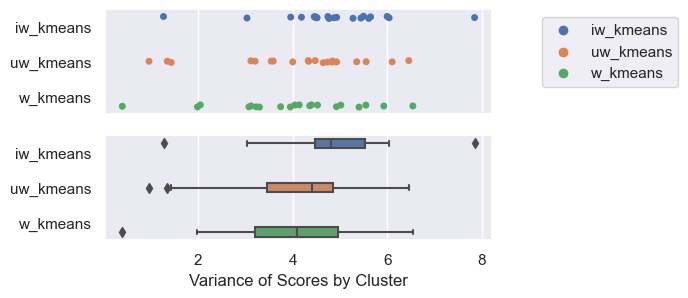

In [12]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='var_score', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='var_score', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Variance of Scores by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()

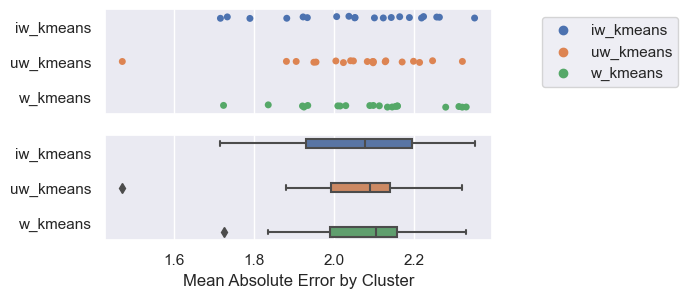

In [13]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='mean_absolute_error', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='mean_absolute_error', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Mean Absolute Error by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()

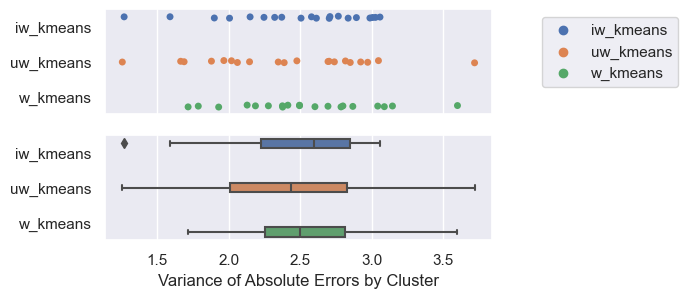

In [14]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='var_absolute_error', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='var_absolute_error', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Variance of Absolute Errors by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()

<AxesSubplot:>

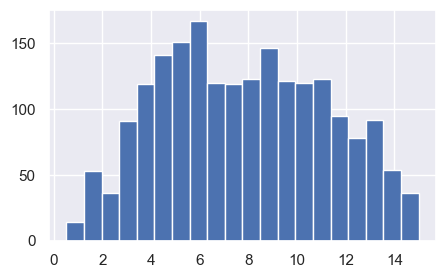

In [15]:
race_df['fk_score'].hist(bins=20)

In [27]:
len(race_df[race_df['fk_score'] <= 4])

291

In [32]:
aspect_embedding = np.mean(race_df[race_df['fk_score'] <= 4]['embeddings_mini_lm'])

# optionally weight the aspect embeddings with the classifier / regression model coefficients
aspect_embedding = aspect_embedding * clf.coef_

aspect_embedding = aspect_embedding / np.linalg.norm(aspect_embedding)

race_df['w_embeddings'] = race_df['embeddings_mini_lm']
race_df['iw_embeddings'] = race_df['embeddings_mini_lm']

alpha = 2
for i, embedding in enumerate(race_df['embeddings_mini_lm']):
    embedding = embedding / np.linalg.norm(embedding)
    projection = np.dot(embedding, aspect_embedding.T) * aspect_embedding
    projection = projection.reshape(-1,)
    race_df['w_embeddings'].iloc[i] = embedding + alpha * projection
    race_df['iw_embeddings'].iloc[i] = embedding - alpha * projection


In [33]:
n_clusters = 40
seed=0
uw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in race_df['embeddings_mini_lm']])
w_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in race_df['w_embeddings']])
iw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in race_df['iw_embeddings']])

race_df['uw_kmeans'] = uw_kmeans.labels_
race_df['w_kmeans'] = w_kmeans.labels_
race_df['iw_kmeans'] = iw_kmeans.labels_

cluster_df = race_df[['uw_kmeans', 'w_kmeans', 'iw_kmeans', 'score', 'absolute_error']]
cluster_df = pd.melt(cluster_df, id_vars=['score', 'absolute_error'], var_name='weighting', value_name='cluster_id')
cluster_df = cluster_df.groupby(['weighting', 'cluster_id']).agg({'score': ['mean', 'var'], 'absolute_error': ['mean', 'var']}).reset_index()
cluster_df.columns = ['weighting', 'cluster_id', 'mean_score', 'var_score', 'mean_absolute_error', 'var_absolute_error']

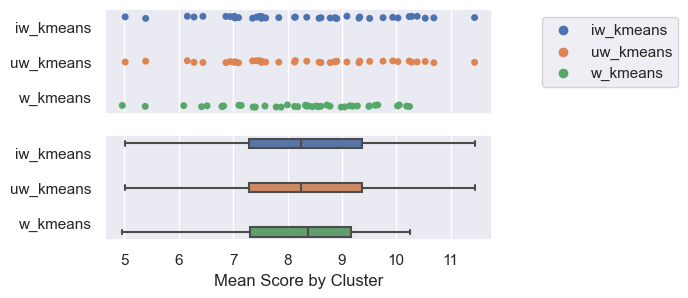

In [34]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='mean_score', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='mean_score', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Mean Score by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()

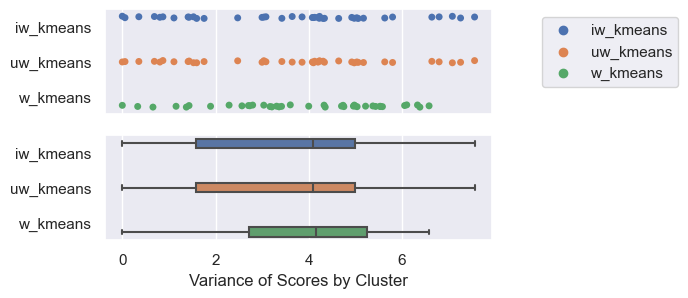

In [35]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='var_score', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='var_score', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Variance of Scores by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()